In [337]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
import scipy as sp
import lightkurve as lk
import pylab as pl
from IPython import display
import pandas as pd
import copy
from itertools import repeat
from echelle import plot_echelle, interact_echelle

In [399]:
# star = 'TIC171591531'
star = 'HD20203'
# star = 'V647Tau'
lk_search = lk.search_lightcurve(star, mission="TESS", cadence=120)
lk_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,274038922,0.0
1,TESS Sector 04,2018,TASOC,120,274038922,0.0
2,TESS Sector 31,2020,SPOC,120,274038922,0.0


In [400]:
lc = lk_search[0].download().remove_nans().remove_outliers()

# Extract time and flux from the light curve
time = lc.time.value
flux = lc.flux.value

In [401]:
def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    amp = np.sqrt(4./len(t)) * np.sqrt(sc)

    return freq, amp

def make_id_strings(ids):
    id_strings = []
    ids = ids.query("n_obs==n_obs") # remove rows without radial order assignments (modes without IDs)
    if "m_obs" not in ids.columns:
        ids["m_obs"] = np.zeros(len(ids)) # create m_obs, but set to zero, if this column doesn't exist
    for i,row in ids.iterrows():
        id_strings.append(str(int(row["n_obs"]))+str(int(row["l_obs"]))+str(int(row["m_obs"])))
    ids["nlm"] = id_strings
    return ids

def extra_echelle(f,a,ids,Dnu=6.83,obs_freqs=None,ax=None,plain=True,title=None,savefilename=None):
    """
    Plots the echelle diagram for a frequency and amplitude spectrum, including ell=2 and ell=3 modes.
    Inputs:
        f = frequency array
        a = amplitude array (same size as f, preferably smoothed)
        ids = Pandas df containing, e.g. frequencies and mode IDs.
        Dnu = 6.83 (not automatically determined)
        obs_freqs = None (for plotting observed frequencies with IDs when also plotting a full ts)
        plain = True (do not plot symbols if plain==True)
        title = None (supply a plot title)
        savefilename = None (supply a filename (incl. extension) to save plot)
    """

    norders = 15 # number of orders to plot

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8.5))
    ax2 = plot_echelle(f, a, Dnu, ax=ax, fmin=0, fmax=Dnu*(norders+1), mirror=True, scale='sqrt')
    ax.set_xlim(0, 1.2*Dnu)
    ax2.set_ylabel(r"Frequency (d$^{-1}$)")
    ax2.set_xlabel(r"Frequency mod $\Delta\nu$ (d$^{-1}$)")
    ax.set_ylim([0,Dnu*norders])
    plt.plot([Dnu, Dnu], [0, Dnu*norders], linestyle='dashed', color = 'blue')
    if title is not None:
        plt.title(f"{title}")

    if obs_freqs is not None:
        # obs radial modes
        add_echelle(obs_freqs.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

        # obs dipole modes
        add_echelle(obs_freqs.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
        
        # obs quadrupole modes
        add_echelle(obs_freqs.query("l_obs==2")["f_obs"],Dnu,'r','s','full',ax2,r'obs $\ell=2$')
        
        # obs octupole modes
#         add_echelle(obs_freqs.query("l_obs==3")["f_obs"],Dnu,'r','v','full',ax2,r'obs $\ell=3$')
        
        # obs no-id modes
        add_echelle(obs_freqs.query("l_obs==-1")["f_obs"],Dnu,'brown','x','full',ax2,r'unidentified')
        add_echelle(obs_freqs.query("m_obs==-9")["f_obs"],Dnu,'brown','+','full',ax2,r'unidentified')

    if plain==False:
        try:
            # obs radial modes
            add_echelle(ids.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

            # obs dipole modes
            add_echelle(ids.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
            
            # obs quadrupole modes
            add_echelle(ids.query("l_obs==2")["f_obs"],Dnu,'r','s','full',ax2,r'obs $\ell=2$')

            add_echelle(obs_freqs.query("m_obs==-9")["f_obs"],Dnu,'brown','+','full',ax2,r'unidentified')

            # obs octupole modes
#             add_echelle(ids.query("l_obs==3")["f_obs"],Dnu,'r','v','full',ax2,r'obs $\ell=3$')
        except:
            # print("could not find observed freqs")
            pass
        
        try:
            # model radial modes
            add_echelle(ids.query("l==0")["freq"],Dnu,'k','o','none',ax2,r'mdl $\ell=0$')
    
            # model dipole modes
            add_echelle(ids.query("l==1")["freq"],Dnu,'k','^','none',ax2,r'mdl $\ell=1$')

            # model quadrupole modes
            add_echelle(ids.query("l==2")["freq"],Dnu,'k','s','none',ax2,r'mdl $\ell=2$')
    
            # model octupole modes
            add_echelle(ids.query("l==3")["freq"],Dnu,'k','v','none',ax2,r'mdl $\ell=3$')
        except:
            # print("could not find model freqs")
            pass

    ax2.text(Dnu, Dnu*0.8, r"$\Delta\nu={:.2f}\thinspace$ ".format(Dnu), horizontalalignment='right', color='blue')

    try:
        ax.legend(fontsize='x-small')
    except:
        pass
    
    if savefilename is not None:
        plt.savefig(f"stars/{savefilename}",bbox_inches='tight')


def add_echelle(freq,Dnu,col,sym,fill,ax2,lbl=None):
    freq_x = np.mod(freq, Dnu) 
    freq_y = freq - np.mod(freq, Dnu) + Dnu/2.
    ax2.plot(freq_x, freq_y, c=col, marker=sym, linestyle='none', fillstyle=fill,label=lbl)
    ax2.plot(freq_x+Dnu, freq_y-Dnu, c=col, marker=sym, linestyle='none', fillstyle=fill)



Done!


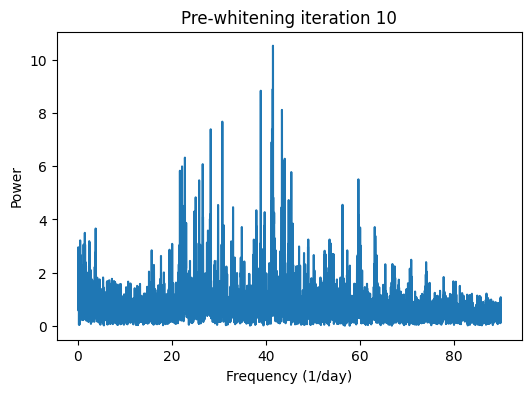

In [407]:
# Define a sinusoidal function to fit the peaks
def sinusoidal_model(t, A, omega, phi, C):
    return A * np.sin(omega * t + phi) + C

def prewhitener(time, flux, f_sigma=3, remove_harmonics=True, max_iterations=5, fmin=None, fmax=90, nyq_mult=1, oversample_factor=5, name='star'):
    if not os.path.exists(f'pw/{name}'):
        os.makedirs(f'pw/{name}')
    else:
        shutil.rmtree(f'pw/{name}')
        os.makedirs(f'pw/{name}')

    flux_i = copy.deepcopy(flux)
    freqs, amps = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    freqs_i = copy.deepcopy(freqs)
    amps_i = copy.deepcopy(amps)
    peaks = np.array([], dtype=int)

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    peak_freqs = np.array([])
    peak_amps = np.array([])
    for n in range(max_iterations):
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)

        # Find peaks in the periodogram
        peaks_tmp = find_peaks(amps_i)[0]
        peaks_widths_i = peak_widths(amps_i, peaks=peaks_tmp, rel_height=0.7)[0]
        width = np.median(peaks_widths_i)
        distance = width/(np.median(np.diff(freqs_i))-10*np.std(np.diff(freqs_i)))
        # prominence = np.median(sp.signal.peak_prominences(amps_i, peaks=peaks_tmp, wlen=(width+3*np.std(width)))[0])
        prominence = np.median(peak_prominences(amps_i, peaks=peaks_tmp)[0])

        peaks_i = find_peaks(amps_i, height=np.median(amps_i)+f_sigma*np.std(amps_i), width=width, prominence=prominence, distance=distance)[0]

        ## If no peaks are found, break the loop
        if len(peaks_i) == 0:
            break

        peaks = np.append(peaks, peaks_i)

        peak_freqs_i = []
        peak_amps_i = []
        for i, freq in enumerate(freqs_i[peaks_i]):
            omega = 2 * np.pi * freq
            p0 = [amps_i[peaks_i][i], omega, 0, 0]
            params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
            if params[0] < 0:
                params[0] *= -1.
                params[2] += np.pi

            peak_freqs_i.append(params[1]/(2*np.pi))
            peak_amps_i.append(params[0])
            # peak_freqs_i.append(freq)
            # peak_amps_i.append(amps_i[peaks_i][i]) 
            
            # # Subtract the fitted sinusoid from the original signal
            flux_i -= sinusoidal_model(time, *params)
            freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)

        # Plot the periodogram
        ax.cla()
        ax.plot(freqs_i, amps_i)
        ax.set_title(f"Pre-whitening iteration {n+1}")
        ax.set_xlabel("Frequency (1/day)")
        ax.set_ylabel("Power")
        plt.savefig(f'pw/{name}/pg_{n+1}')
        peak_freqs = np.append(peak_freqs, peak_freqs_i)
        peak_amps = np.append(peak_amps, peak_amps_i)

    ## freqs of these sorted peaks
    peak_freqs = peak_freqs[np.argsort(peak_amps)[::-1]]
    ## sort frequencies in ascending order
    peak_amps = sorted(peak_amps, reverse=True)

    if remove_harmonics:
        # # # Harmonic ratio checking
        tolerance = 0.01 
        harmonics_idx = []
        for i in range(len(peak_freqs)):
            for j in range(i+1, len(peak_freqs)):
                ratio = peak_freqs[j]/peak_freqs[i]
                if np.abs(ratio - round(ratio)) < tolerance:
                    harmonics_idx.append(j)
        peak_freqs = np.delete(peak_freqs, harmonics_idx)
        peak_amps = np.delete(peak_amps, harmonics_idx)

    print('Done!')
    return peaks, peak_freqs, peak_amps, freqs, amps


peaks, peak_freqs, peak_amps, freqs, amps = prewhitener(time, flux, fmax=90, max_iterations=10)

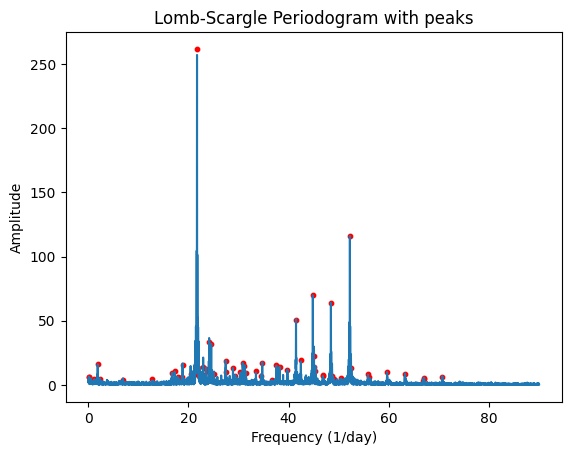

In [408]:
# Plot the final periodogram after pre-whitening
plt.figure()
plt.scatter(peak_freqs, peak_amps, s=10, color='red')
plt.plot(freqs, amps)
plt.title("Lomb-Scargle Periodogram with peaks")
plt.xlabel("Frequency (1/day)")
plt.ylabel("Amplitude")
# plt.xlim(30, 50)
# plt.xlim(40, 60)
# plt.xlim(15, 30)
# plt.xlim(0, 15)
plt.show()

# Show the frequencies that were found
# print("Frequencies found through pre-whitening: ", freqs_at_peaks)

In [404]:
len(peak_freqs), len(peak_freqs), len(peak_amps), len(peaks)

(29, 29, 29, 50)

In [355]:
### Load star IDs
dtypes = {'ID': 'str', 'f_obs': 'float', 'a_obs': 'float', 'n_obs': 'int', 'l_obs': 'int', 'm_obs': 'int'}
# ids = pd.read_csv(f"stars/HD23642_revised_ids_all3.csv", delim_whitespace=True, dtype=dtypes)
ids2 = pd.DataFrame()
ids2["ID"] = np.arange(1, len(peak_freqs)+1)
ids2["f_obs"], ids2["a_obs"], ids2['n_obs'], ids2['l_obs'], ids2['m_obs'] = peak_freqs, peak_amps, 6, -1, -9
ids2 = make_id_strings(ids2)
# ids


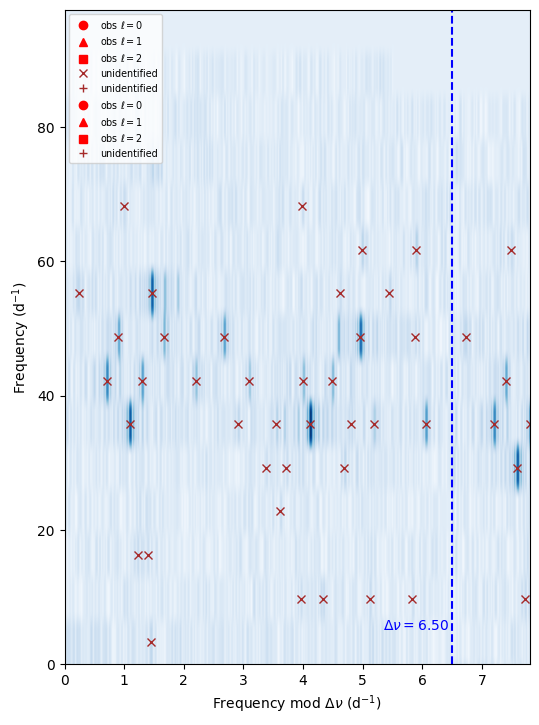

In [374]:
Dnu = 6.5
# extra_echelle(freqs, amps, ids, obs_freqs=ids, Dnu=Dnu, plain=False)
extra_echelle(freqs, amps, ids2, obs_freqs=ids, Dnu=Dnu, plain=False)

In [334]:
# Fold the light curve at the frequency of the highest peak for visualization
highest_peak_frequency = peak_freqs[0]
folded_time = time % (1 / highest_peak_frequency)

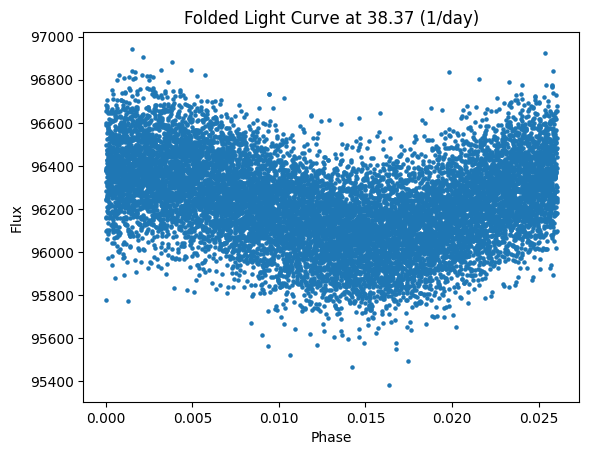

In [282]:
# Plot folded light curve
plt.figure()
plt.scatter(folded_time, flux, s=5)
plt.title(f"Folded Light Curve at {highest_peak_frequency:.2f} (1/day)")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.show()

In [6]:
x = [1,2,3,4,5]

In [7]:
x.pop(0)

1